In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier,VotingClassifier
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from matplotlib.colors import Normalize
from matplotlib import cm


import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def preprocessing(data):
    le = LabelEncoder()
    
    ## Host response time
    ### Fill NA with blank
    ### Label encode them - NA is 0
    data['Host_response_time'] = data['Host_response_time'].fillna('')
    data['Host_response_time'] = le.fit_transform(data['Host_response_time'])
    
    ## Host is superhost
    ### Fill NA with false
    ### Label encode them 
    data.Host_is_superhost = data.Host_is_superhost.fillna('f')
    data.Host_is_superhost = le.fit_transform(data.Host_is_superhost)

    ## Host has profile pic
    data.Host_has_profile_pic = data.Host_has_profile_pic.fillna('f')
    data.Host_has_profile_pic = le.fit_transform(data.Host_has_profile_pic)

    ## Host has identity verified
    data.Host_identity_verified = data.Host_identity_verified.fillna('f')
    data.Host_identity_verified = le.fit_transform(data.Host_identity_verified)
    
    ## Neighbourhood
    one_hot_neighbourhood = pd.get_dummies(data.Neighbourhood, prefix = "zip", drop_first=True,dtype='int64')
    data = data.drop('Neighbourhood', axis = 1)
    data = data.join(one_hot_neighbourhood)
    
    ## Property type
#     data.Property_type = data.Property_type.str.replace(" \(condo\)","")
#     data.Property_type = data.Property_type.str.replace(" \(Cuba\)","")
#     one_hot_prop_type = pd.get_dummies(data.Property_type, prefix = "prop", drop_first=True,dtype='int64')
#     data = data.drop('Property_type', axis = 1)
#     data = data.join(one_hot_prop_type)
    
    ## Room type
    one_hot_room_type = pd.get_dummies(data.Room_type, prefix = "room", drop_first=True,dtype='int64')
    data = data.drop('Room_type', axis = 1)
    data = data.join(one_hot_room_type)
    
    ## Bathrooms text
    data["Shared_bath"] = 0
    mask = data.Bathrooms_text.str.contains("shared")
    data.loc[mask, "Shared_bath"] = 1
    
    data["Num_baths"] = data.Bathrooms_text.str.extract('(\d*\.\d+|\d+)',expand = False).astype('float')
    
    mask = data.Bathrooms_text.str.contains("alf-bath")
    data.loc[mask, 'Num_baths'] = 0.5
    
    data = data.drop('Bathrooms_text', axis = 1)
    
    ## Bedrooms
#     mean_bedrooms = data.Bedrooms.mean()
    data.Bedrooms.fillna(0, inplace=True)
    
    ## Beds
    data.Beds.fillna(0, inplace = True)
    
    ## Price
    data.Price = data.Price.replace('[\$,]', '', regex=True).astype(float)
    
    ## Review scores rating - drop where missing
#     mean_review = data.Review_scores_rating.mean()
#     data.Review_scores_rating.fillna(mean_review, inplace=True)
#     data = data[data.Review_scores_rating.notna()]
    
    ## Instant bookable
    data.Instant_bookable = le.fit_transform(data.Instant_bookable)
    
    ## Month
    one_hot_month_type = pd.get_dummies(data.Month, prefix = "month", drop_first=True, dtype='int64')
    data = data.drop('Month', axis = 1)
    data = data.join(one_hot_month_type)
    
    ## Drop id
    data = data.drop(["id","Property_type","Review_scores_rating"], axis = 1)

    return data

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [4]:
train_data.head()

,id,Decision,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,...,Beds,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month
0,1,1,within an hour,t,t,t,28806,Entire cabin,Entire home/apt,6,...,3.0,5,5,1,1,$164.00,90,4.93,t,August
1,2,1,within an hour,t,t,t,28804,Entire house,Entire home/apt,4,...,1.0,5,4,1,1,$101.00,522,4.69,t,June
2,3,0,within a few hours,t,t,t,28806,Private room in bungalow,Private room,1,...,1.0,5,3,1,1,$32.00,35,4.83,f,June
3,4,1,within an hour,t,t,t,28803,Entire condominium (condo),Entire home/apt,8,...,5.0,5,5,0,1,$381.00,11,5.00,t,September
4,5,0,within an hour,t,t,t,28805,Entire house,Entire home/apt,6,...,4.0,5,5,1,1,$238.00,63,4.70,f,July


In [5]:
test_data.head()

,id,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,Bathrooms_text,...,Beds,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month
0,1,NaN,t,t,t,28806,Private room in bungalow,Private room,1,1 private bath,...,1.0,4,3,1,1,$58.00,137,4.85,f,September
1,2,within an hour,t,t,t,28805,Entire apartment,Entire home/apt,2,1 bath,...,1.0,5,5,1,1,$76.00,573,4.93,t,June
2,3,within an hour,t,t,t,28805,Entire rental unit,Entire home/apt,2,1 bath,...,1.0,5,5,1,1,$76.00,590,4.93,t,August
3,4,within an hour,t,t,t,28805,Entire rental unit,Entire home/apt,2,1 bath,...,1.0,5,5,1,1,$76.00,600,4.93,t,September
4,5,within an hour,t,t,t,28805,Entire apartment,Entire home/apt,2,1 bath,...,1.0,5,5,1,1,$76.00,581,4.93,t,July


In [6]:
sample_submission.head()

,id,Decision
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


Preprocessing train data and splitting into train and val sets. The val set here is called the test set because of ease of notation.

In [7]:
processed_train = preprocessing(train_data)
# processed_train = processed_train[processed_train.Review_scores_rating.notna()]
X = processed_train.drop('Decision', axis = 1)
y = processed_train.Decision

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)
print(len(X), len(X_train))

7471 5976


In [9]:
print("No Samples:\t%d" % X_train.shape[0])
print("No Features:\t%d" % X_train.shape[1])
print("Negative decision:\t%d" % (y_train==0).sum())
print("Positive decision:\t%d" % (y_train==1).sum())

No Samples:	5976
No Features:	29
Negative decision:	2188
Positive decision:	3788


# Logistic Regression

0.2936454849498328


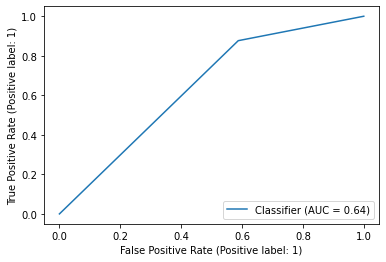

In [43]:
logistic_cv = LogisticRegressionCV(cv = 10, solver='liblinear',random_state=1, verbose=0, n_jobs=-1)
logistic_cv.fit(X_train, y_train)
print(1-logistic_cv.score(X_test, y_test))
y_pred_lr = logistic_cv.predict(X_test)
logistic_cv.get_params()
RocCurveDisplay.from_predictions(y_test, y_pred_lr)
plt.show()

# Random Forest

In [66]:
params = {"n_estimators": np.arange(100,500,100),
         "max_features":np.array((None,"sqrt"))}
accuracy_values = []
rf = RandomForestClassifier(class_weight = "balanced_subsample", n_jobs = -1,random_state = 1)
gridsearch_rf = GridSearchCV(rf,params,cv=10, scoring="accuracy", n_jobs = -1, verbose = 1)
gridsearch_rf.fit(X_train,y_train)
y_pred = gridsearch_rf.predict(X_test)
accuracy_values.append(metrics.accuracy_score(y_test, y_pred))
print(gridsearch_rf.best_params_)
print("Random Forest") 
print("Val Accuracy:\t%.2f" % (1-np.mean(accuracy_values)))


Fitting 10 folds for each of 8 candidates, totalling 80 fits
{'max_features': None, 'n_estimators': 400}
Random Forest
Val Accuracy:	0.19


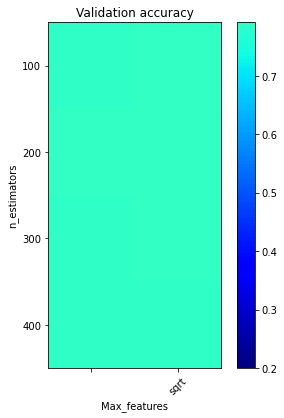

In [65]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

n_est = np.arange(100,500,100)
max_fea = np.array((None,"sqrt"))
scores = gridsearch_rf.cv_results_["mean_test_score"].reshape(len(n_est), len(max_fea))
plt.figure(figsize=(6, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap = cm.jet,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("Max_features")
plt.ylabel("n_estimators")
plt.colorbar()
plt.xticks(np.arange(len(max_fea)), max_fea, rotation=45)
plt.yticks(np.arange(len(n_est)), n_est)
plt.title("Validation accuracy")
plt.show()

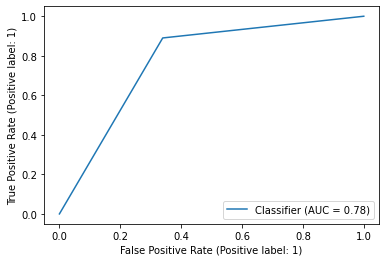

In [15]:
rf_best = RandomForestClassifier(n_estimators=400, max_features= None,class_weight = "balanced_subsample", n_jobs = -1,random_state = 1)
rf_best.fit(X_train,y_train)
y_pred_test_rf = rf_best.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_test_rf)
plt.show()

# SVM

In [16]:
params = {"svc__C": np.logspace(-4,4,5),
          "svc__gamma": np.logspace(-4,4,5)}
accuracy_values = []
svc = make_pipeline(StandardScaler(), SVC(kernel = 'rbf'))
gridsearch = GridSearchCV(svc,params,cv=10, scoring="accuracy", n_jobs = -1, verbose = 1)
gridsearch.fit(X_train,y_train)
y_pred = gridsearch.predict(X_test)
accuracy_values.append(metrics.accuracy_score(y_test, y_pred))
print(gridsearch.best_params_)
print("SVM") 
print("Test Accuracy:\t%.2f (+-%.2f)" % 1-(np.mean(accuracy_values),np.std(accuracy_values)))


Fitting 10 folds for each of 25 candidates, totalling 250 fits
{'svc__C': 100.0, 'svc__gamma': 0.01}
SVM
Test Accuracy:	0.76 (+-0.00)


In [17]:
gridsearch.best_params_

{'svc__C': 100.0, 'svc__gamma': 0.01}

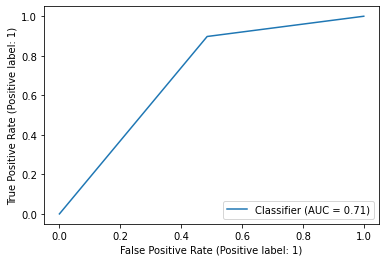

In [18]:
svm_best = make_pipeline(StandardScaler(), SVC(C = gridsearch.best_params_['svc__C'], gamma=gridsearch.best_params_['svc__gamma']))
svm_best.fit(X_train, y_train)
y_pred_test_svm = svm_best.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_test_svm)
plt.show()

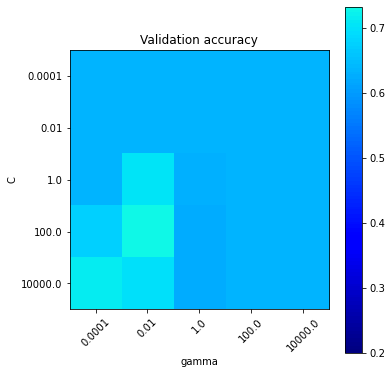

In [62]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

C_range = np.logspace(-4,4,5)
gamma_range = np.logspace(-4,4,5)
scores = gridsearch.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))
plt.figure(figsize=(6, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap = cm.jet,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()

# Stacked

In [19]:
svm = make_pipeline(StandardScaler(), SVC(C = 100, gamma = 0.01))
logistic_cv = LogisticRegressionCV(cv = 10, solver='liblinear',random_state=1, verbose=0, n_jobs=4)
random_forest = RandomForestClassifier(min_samples_split = 0.1,class_weight = "balanced_subsample", n_jobs = -1,random_state = 1)
stack = StackingClassifier(estimators=[('svm',svm),('lrcv',logistic_cv),('rf',random_forest)], n_jobs=-1,verbose=1)
stack.fit(X_train, y_train)
print(1-stack.score(X_test, y_test))

0.2341137123745819


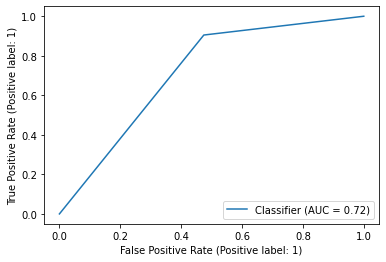

In [20]:
y_pred_test_stack = stack.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_test_stack)
plt.show()

<Figure size 600x600 with 0 Axes>

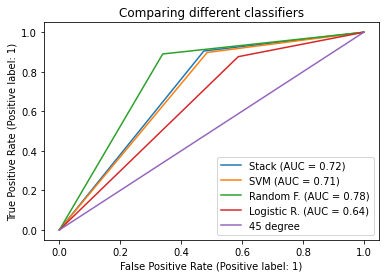

In [33]:
plt.figure(figsize=(6,6), dpi = 100)
fig = RocCurveDisplay.from_predictions(y_test, y_pred_test_stack, name = "Stack")
fig = RocCurveDisplay.from_predictions(y_test, y_pred_test_svm, name = "SVM", ax=fig.ax_)
fig = RocCurveDisplay.from_predictions(y_test, y_pred_test_rf, name = "Random F.", ax=fig.ax_)
fig = RocCurveDisplay.from_predictions(y_test, y_pred_lr, name = "Logistic R.", ax=fig.ax_)
plt.plot([0,1],[0,1], label = "45 degree")
plt.legend()
plt.title("Comparing different classifiers")
plt.show()

<Figure size 600x600 with 0 Axes>

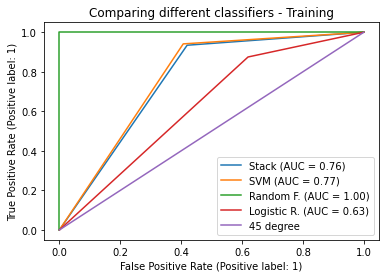

In [48]:
plt.figure(figsize=(6,6), dpi = 100)
y_pred_train_stack = stack.predict(X_train)
fig = RocCurveDisplay.from_predictions(y_train, y_pred_train_stack, name = "Stack")
y_pred_train_svm = svm_best.predict(X_train)
fig = RocCurveDisplay.from_predictions(y_train, y_pred_train_svm, name = "SVM", ax=fig.ax_)
y_pred_train_rf = rf_best.predict(X_train)
fig = RocCurveDisplay.from_predictions(y_train, y_pred_train_rf, name = "Random F.", ax=fig.ax_)
y_pred_train_lr = logistic_cv.predict(X_train)
fig = RocCurveDisplay.from_predictions(y_train, y_pred_train_lr, name = "Logistic R.", ax=fig.ax_)
plt.plot([0,1],[0,1], label = "45 degree")
plt.legend()
plt.title("Comparing different classifiers - Training")
plt.show()

# Predict on the unknown data

In [26]:
processed_test = preprocessing(test_data)
processed_test.shape

(2440, 29)

In [28]:
# y_pred = logistic_cv.predict(processed_test)
# y_pred = rf_best.predict(processed_test)
# y_pred = svm.predict(processed_test)
# y_pred = bag.predict(processed_test)
y_pred = stack.predict(processed_test)
submission = pd.DataFrame()
submission['id'] = test_data['id']
submission['Decision'] = y_pred
submission.to_csv("submission.csv", index= False)
print("done")

done


In [44]:
print(1-stack.score(X_test, y_test))
print(1-svm_best.score(X_test, y_test))
print(1-rf_best.score(X_test, y_test))
print(1-logistic_cv.score(X_test, y_test))

0.2341137123745819
0.242809364548495
0.19397993311036787
0.2936454849498328


# Print confusion matrices

Stacked confusion matrix


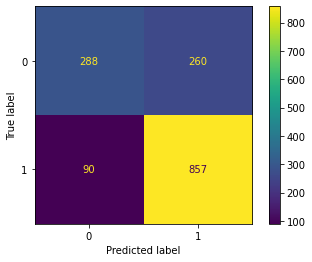

In [46]:
print("Stacked confusion matrix")
ConfusionMatrixDisplay.from_predictions(y_true=y_test,  y_pred=y_pred_test_stack)

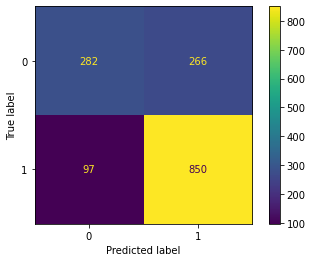

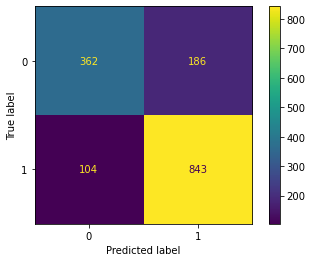

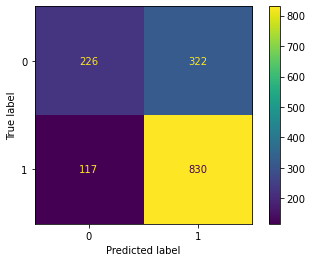

In [47]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test,  y_pred=y_pred_test_svm)
ConfusionMatrixDisplay.from_predictions(y_true=y_test,  y_pred=y_pred_test_rf)
ConfusionMatrixDisplay.from_predictions(y_true=y_test,  y_pred=y_pred_lr)

## Experimental models not used

In [22]:
# for i in range(10,20):
svm = make_pipeline(StandardScaler(), SVC(C = 100, gamma = 0.01))
bag = BaggingClassifier(base_estimator=svm, n_estimators=15, n_jobs=-1,verbose=1,random_state=0)
bag.fit(X_train, y_train)
print(1-bag.score(X_test, y_test))

In [13]:
svm = make_pipeline(StandardScaler(), SVC(C = 100, gamma = 0.01))
bag = BaggingClassifier(base_estimator=svm, n_estimators=15, n_jobs=-1,verbose=1,random_state=0)
logistic_cv = LogisticRegressionCV(cv = 10, solver='liblinear',random_state=1, verbose=0, n_jobs=4)
random_forest = RandomForestClassifier(min_samples_split = 0.1,class_weight = "balanced_subsample", n_jobs = -1,random_state = 1)
stack = StackingClassifier(estimators=[('bag',bag),('lrcv',logistic_cv),('rf',random_forest)], n_jobs=-1,verbose=1)
stack.fit(X_train, y_train)
print(1-stack.score(X_test, y_test))